# PCA: Food Consumption in European Area

# 1) Spectral Clustering

**1) Consider an undirected graph with non-negative edge weights $wij$ and graph Laplacian $L$. Suppose there are $m$ connected components $A1,A2,...,Am$ in the graph. Show that there are $m$ eigenvectors of $L$ corresponding to eigenvalue zero, and the indicator vectors of these components $I_{A_1} , ... , I_{A_m}$ span the zero eigenspace.**

Lets begin with the definition of the graph Laplacian...

$$
\begin{equation*}
L = 
\begin{pmatrix}
L_1 & 0 & \cdots & 0 \\
0 & L_2 & \cdots & 0 \\
\vdots  & \vdots  & \ddots & \vdots  \\
0 & 0 & \cdots & L_m 
\end{pmatrix}
\end{equation*}
$$

Connected component $m$ is represented in the graph Laplacian as block $L_m$

Expanding block $L_m$ into its components we see...

$$
\begin{equation*}
L_m = 
\begin{pmatrix}
\sum_i w_{1i} & -w_{11} & -w_{12}  & \cdots & -w_{1n}  \\
-w_{21} & \sum_i w_{2i} & -w_{22}  & \cdots & -w_{2n}  \\
-w_{31} & -w_{32} & \sum_i w_{3i}  & \cdots & -w_{3n}  \\
\vdots & \vdots & \vdots  & \ddots & \vdots  \\
-w_{n1} & -w_{n2} & -w_{n3}  & \cdots & \sum_i w_{ni} \\
\end{pmatrix}
\end{equation*}
$$

Since L is symmetric, $w_{ij} = w_{ji}$

From this representation, we can tell that all rows and all columns sum to zero. 

Since all rows sum to zero, the ones-vector of length m is a zero-eigenvector of $L_m$

 

To expand this up from $L_m$ and generalize to $L$, we can can construct the vector shown below. In this case, all of the $1$ entries line up exactly with the elements of block $L_m$, and the vector is 0 everywhere else.

Thus we have a zero-eigenvector of L. 

$$
\begin{equation*}
I_m = 
\begin{pmatrix}
0 \\
0 \\
\vdots \\
1 \\
1 \\
\vdots \\
1 \\
1 \\
0 \\
0 \\
\vdots \\
0 \\
\end{pmatrix}
\end{equation*}
$$

Since all of the $L_m$ blocks are adjacent, we can construct L linearly independent zero-eigenvectors of the form shown above. Thus these L vectors span the zero-eigenspace.  

------
------

**2) Real data: political blogs dataset. We will study a political blogs dataset ﬁrst compiled for the paper Lada A. Adamic and Natalie Glance, “The political blogosphere and the 2004 US Election”, in Proceedings of the WWW-2005 Workshop on the Weblogging Ecosystem (2005). The dataset `nodes.txt` contains a graph with $n = 1490$ vertices (“nodes”) corresponding to political blogs. Each vertex has a $0-1$ label (in the 3rd column) corresponding to the political orientation of that blog. We will consider this as the true label and try to reconstruct the true label from the graph using the spectral clustering on the graph. The dataset `edges.txt` contains edges between the vertices.** 

Here we assume the number of clusters to be estimated is $k = 2$. Using spectral clustering to ﬁnd the 2 clusters. Compare the clustering results with the true labels. What is the false classiﬁcation rate (the percentage of nodes that are classiﬁed incorrectly).

In [244]:
import warnings
warnings.filterwarnings('ignore')

import time
import pandas as pd
import numpy as np
import scipy.sparse.linalg as ll
import matplotlib.pyplot as plt

'''
0. Rewrite K-Means functions from Homework 1
1. Read and clean the data.
2. Create the Laplacian matrix.
3. Calculate the eigen decomposition and sort based on smallest eigenvalues.
4. Run k-means on the 2 smallest eigenvalues to classify the data.
'''

##################################################################
# Rewrite K-Means Code from HW 1
##################################################################

# Step 1. initialize the means.
def initialize_means(data, K, rand_seed=1):
    np.random.seed(rand_seed)
    means = np.random.choice(len(data), replace=False, size=K)
    return data[means, :]

# Step 2. Calculate distances from each point to the mean of each cluster
def calculate_distances_to_means(data, means, l_norm=2):
    num_points = len(data)
    K = len(means)
    dists = np.zeros((num_points, K))
    for i in range(num_points):
        dist = np.linalg.norm(data[i,:] - means, axis=1, ord=l_norm)
        dists[i,:] = dist**l_norm
    return dists

# Step 3. Assign each data point to a cluster based on the distances calculated in step 3.
def assign_each_point_to_closest_mean(dists):
    return np.argmin(dists, axis=1)
    
# Step 4. Update the means based on the fixed cluster assignments.
def update_means(data, means, l_norm=2):
    new_means = np.zeros(means.shape)
    distances = calculate_distances_to_means(data, means, l_norm)
    labels = assign_each_point_to_closest_mean(distances)
    
    for cluster in set(labels):
        points_in_cluster = np.array([data[j] for j in range(len(data)) if labels[j] == cluster])
        new_means[cluster] = np.mean(points_in_cluster, axis=0)

    return new_means

# Step 5. 
def check_for_convergence(means, new_means):
    return np.array_equal(means, new_means)

# Putting it all together.
def k_means(data, K, max_iterations = 10, l_norm = 2):
    print('Running k_means...')
    t0 = time.time()
    converged = False
    means = initialize_means(data, K)
    iteration = 1
    
    while (not converged) and (iteration < max_iterations):

        distances = calculate_distances_to_means(data, means, l_norm)
        labels = assign_each_point_to_closest_mean(distances)
        new_means = update_means(data, means)
        
        converged = check_for_convergence(means, new_means)
        means = new_means
        iteration += 1

    t1 = time.time()
    runtime = round(t1-t0)
    
    return labels, means, iteration, runtime
        
##################################################################
# End of K-Means code
##################################################################


In [245]:
def spectral_clustering(k):
    k = k
    
    ''' Read the data '''
    nodes = pd.read_csv('nodes.txt', sep='\t', names=['index', 'url', 'label', 'category'])
    nodes['index'] = nodes['index'] - 1
    edges = pd.read_csv('edges.txt', sep='\t', names=['from', 'to'])
    edges['from'] = edges['from'] - 1
    edges['to'] = edges['to'] - 1

    ''' Clean the data '''
    # Build adjacency matrix
    A = np.zeros(shape=(len(nodes),len(nodes)))
    for index, row in edges.iterrows():
        f = row['from']
        t = row['to']
        if f != t:
            A[f,t] = 1
            A[t,f] = 1

    # Find indices of all nodes that are connected to other nodes
    A_pd = pd.DataFrame(A)
    A_pd['total_connections'] = A_pd.sum(axis=1)
    nodes_to_keep = A_pd.index[A_pd['total_connections'] != 0].tolist()

    # Filter the adjacency matrix and convert back to numpy array
    A_filtered = A_pd.iloc[nodes_to_keep,nodes_to_keep]
    A_f = A_filtered.values
    #A_sparse = sparse.coo_matrix(A_f)

    # Remove the nodes that had no connections as well
    nodes_pd = pd.DataFrame(nodes)
    nodes_f = nodes.iloc[nodes_to_keep]


    ''' Calculate the Symmetric normalized Laplacian matrix '''
    D = np.diag(np.sum(A_f, axis=1))
    D_norm = np.diag(1/np.sqrt(np.sum(A_f, axis=1)))
    L = D - A_f
    L_sym = D_norm @ L @ D_norm

    ''' Calculate the eigen decomposition and sort based on smallest eigenvalues '''
    values, vectors = np.linalg.eigh(L_sym)
    vectors = vectors.real
    vectors_k = vectors[:, 0:k]
    vectors_k_norm = vectors_k/np.repeat(np.sqrt(np.sum(vectors_k*vectors_k, axis=1).reshape(-1, 1)), k, axis=1)

    ''' Visualize the eigenvectors '''
    # plt.scatter(vectors_k[:, 0], vectors_k[:, 1])
    # plt.show()
    # np.where(values < 0.1)[0]
    # vectors[0]
    # vectors[1]
    # plt.scatter(values, range(len(values)))

    ''' Run K-Means on the eigenvector representation of the data '''

    labels, means, iteration, runtime = k_means(data=vectors_k_norm, K=k, max_iterations=200)
    labels_pd = pd.DataFrame(labels, columns={'label'})
    labels_pd.groupby(by='label').size()

    ''' Compare the predicted labels to the true labels '''
    nodes_f['pred'] = labels
    # nodes_f.head()
    nodes_agg = nodes_f.groupby(by=['label', 'pred']).size().reset_index(name='count').sort_values(by='count', ascending=False)
    print(nodes_agg)

    correct = 0
    labels = list(set(nodes_agg['label']))
    pred_groups = list(set(nodes_agg['pred']))
    for index, row in nodes_agg.iterrows():
        check = row['label'] in (labels) and row['pred'] in (pred_groups)
    #     print(check)
        if check:
            correct += row['count']
            try:
    #             print('label ',int(row['label']))
                labels.pop(int(row['label']))
            except:
                pass
            try:
    #             print('pred ',int(row['pred']))
                pred_groups.pop(int(row['pred']))
            except:
                pass

    grouping_accuracy = correct/sum(nodes_agg['count'])
    print(f'Model accurately grouped {correct} nodes.')
    print(f'Model achieved {round(grouping_accuracy*100,1)} % accuracy!\n')
    print(f'The false classification rate is {round((1-grouping_accuracy)*100,1)} %\n')




In [246]:
spectral_clustering(k=2)

Running k_means...
   label  pred  count
2    1.0     0    636
0    0.0     0    585
1    0.0     1      2
Model accurately grouped 638.0 nodes.
Model achieved 52.2 % accuracy!

The false classification rate is 47.8 %



In [247]:
spectral_clustering(k=3)

Running k_means...
   label  pred  count
4    1.0     1    590
2    0.0     2    540
1    0.0     1     43
5    1.0     2     42
0    0.0     0      4
3    1.0     0      4
Model accurately grouped 1130.0 nodes.
Model achieved 92.4 % accuracy!

The false classification rate is 7.6 %



Above we can see the results of running spectral clustering on the dataset with k=2 and k=3 clusters.

Because there were two datapoints that were connected to each other but were not connected to any others, when we performed spectral clustering using only the two smallest eigenvectors (`k=2`), those two were separated out and all other nodes were placed in the same category. 

This caused us to misclassify all of the other label `0` nodes, leading to a misclassification rate of $47.8\%$.

However when we kept the 3 smallest eigenvectors (`k=3`) and clustered using those, our accuracy improved dramatically. No longer were we forced to group all other nodes into the same category. That allowed us to consistently separate the larger group of nodes into two clusters, with a false classification rate of $7.6\%$.

The aggregated model results are shown above.

# 2) PCA: Food Consumption in European Area

The data `food-consumption.csv` contains 16 countries in the European area and their consumption for 20 food items, such as `tea`, `jam`, `coﬀee`, `yoghurt`, and others. There are some missing data entries: you may remove the rows `Sweden`, `Finland`, and `Spain`. 

The goal is to perform PCA analysis on the data, i.e., ﬁnd a way to perform linear combinations of features across all 20 food-item consumptions, for each country. If we extract two principal components, that means we use two singular vectors that correspond to the largest singular values of the data matrix, in combining features. You will need to implement PCA by writing your own code.

**1) Write down the set-up of PCA for this setting. Explain how the data matrix is set-up in this case (e.g., each dimension of the matrix correspond to what.) Explain in words how PCA is performed in this setting.**

In this problem, each row of the data matrix represents one country in Europe, and each column represents a dimension of the data. Specifically, the dimensions are related to the amount that different types of food are consumed in each country. All dimensions are numeric other than `Country` (which will not be used to form the principal components).

The first 5 rows of the data are shown below.

In [262]:
# Load Data
data = pd.read_csv('food-consumption.csv')
data.head()

,Country,Real coffee,Instant coffee,Tea,Sweetener,Biscuits,Powder soup,Tin soup,Potatoes,Frozen fish,...,Apples,Oranges,Tinned fruit,Jam,Garlic,Butter,Margarine,Olive oil,Yoghurt,Crisp bread
0,Germany,90,49,88,19.0,57.0,51,19,21,27,...,81,75,44,71,22,91,85,74,30.0,26
1,Italy,82,10,60,2.0,55.0,41,3,2,4,...,67,71,9,46,80,66,24,94,5.0,18
2,France,88,42,63,4.0,76.0,53,11,23,11,...,87,84,40,45,88,94,47,36,57.0,3
3,Holland,96,62,98,32.0,62.0,67,43,7,14,...,83,89,61,81,15,31,97,13,53.0,15
4,Belgium,94,38,48,11.0,74.0,37,23,9,13,...,76,76,42,57,29,84,80,83,20.0,5


Principal Component Analysis is preformed by normalizing the data and then analysing how each dimension varies with each other dimension. We do this by constructing a *covariance matrix*. 

Then, using the covariance matrix we construct a new coordinate system based on the directions along which the data varies the most. This is done by calculating the eigenvalues and eigenvectors of the normalized covariance matrix, a process called *eigendecomposition*. 

Each basis of the new coordinate system will be made up of a linear combination of the various dimensions present in the data. For example, one eigenvector might be `0.1*Real Coffee + 0.2*Tea + ... + 1.2*Crisp bread`.

The direction in which the data varies the most is called the *first principal component*. The direction in which the data varies the second most is called the *second principal component*, and so on. 

We can represent the data in both the original coordinate system and the eigenspace without a loss of information, as long as we use all principal components. However, we can compress the data by using a subset of the principal components, and that is the goal of Principal Component Analysis.

**2) Suppose we aim to ﬁnd top $k$ principal components. Write down the mathematical optimization problem involved for solving this problem. Explain the procedure to ﬁnd the top $k$ principal components in performing PCA.**

This explanation comes from the lecture slides.

Given $m$ data points, $\{x^1, x^2, ... , x^m\} \in \mathbb{R}^n$, with mean $\mu = \frac{1}{m} \sum_{i=1}^{m} x^i$,

find a direction $\vec w \in \mathbb{R}^n$ where $|| \vec w || \leq 1$,

such that the variance of the data along direction $\vec w$ is maximized.

$$ \max_{\vec w : || \vec w || \leq 1} \frac{1}{m} \sum_{i=1}^{m} (\vec w^T x^i - \vec w^T \mu)^2 $$

Manipulating the objective function with linear algebra...

$$ \frac{1}{m} \sum_{i=1}^{m} (\vec w^T x^i - \vec w^T \mu)^2 $$

$$ = \frac{1}{m} \sum_{i=1}^{m} (\vec w^T (x^i - \mu))^2 $$

$$ = \frac{1}{m} \sum_{i=1}^{m} \vec w^T (x^i - \mu) (x^i - \mu)^T \vec w $$

$$ = \vec w^T (\frac{1}{m} \sum_{i=1}^{m} (x^i - \mu) (x^i - \mu)^T )\vec w $$

This final expression is the formula for the covariance matrix, $C$

The principal direction $\vec w$ satisfies 

$$C \vec w = \lambda \vec w$$.

The variance in the principal direction is 

$$ \vec w^T C \vec w $$

$$ = \lambda \vec w^T \vec w $$

$$ = \lambda $$

Thus, the eigenvalue is equal to the variance of the data, and the eigenvectors of C correspond to the principal components.

Last, we compute the reduced representation of the data by projecting the data onto the normalized eigenspace. 

$$
\begin{equation*}
z^i = 
\begin{pmatrix}
\vec w^{1^T} (x^i - \mu) / \sqrt{\lambda_1}\\
\vec w^{2^T} (x^i - \mu) / \sqrt{\lambda_2}\\
\vdots \\
\end{pmatrix}
\end{equation*}
$$


#### Code for 2.3 and 2.4.

In [254]:
# Load Data
data = pd.read_csv('food-consumption.csv')
data.head()

# Clean the data
data = data.dropna().reset_index(drop=True)

'''
The data found in 'food-consumption.csv' contains 16 Eurpoean 
countries and their consumption of the following food items:

1. Real coffee
2. Instant coffee
3. Tea
4. Sweetener
5. Biscuits
6. Powder soup
7. Tin soup
8. Potatoes
9. Frozen fish
10. Frozen vegetables
11. Apples
12. Oranges
13. Tinned fruit
14. Jam
15. Garlic
16. Butter
17. Margerine
18. Olive oil
19. Yogurt
20. Crisp bread
'''

# Extract attributes from raw data
Anew = data.iloc[:,1:]
m,n = Anew.shape
foods = data.columns.values

# Create indicator matrix
countries = data.iloc[:,0]

# Normalize data
Anew = Anew/Anew.std(axis=0)
Anew = Anew.T

# # PCA
mu_std = np.mean(Anew,axis = 1)
xc = Anew - mu_std[:,None]

C = np.dot(xc,xc.T)/m

K = 2
S,W = ll.eigs(C,k = K)

dim1 = np.dot(W[:,0].T,xc)/np.sqrt(S[0])
dim2 = np.dot(W[:,1].T,xc)/np.sqrt(S[1])
dim1 = dim1.real # X-values
dim2 = dim2.real # Y-values


**3) Find the top two principal component vectors for the dataset and plot them (plot a value of the vector as a one-dimensional function). Describe do you see any pattern.**

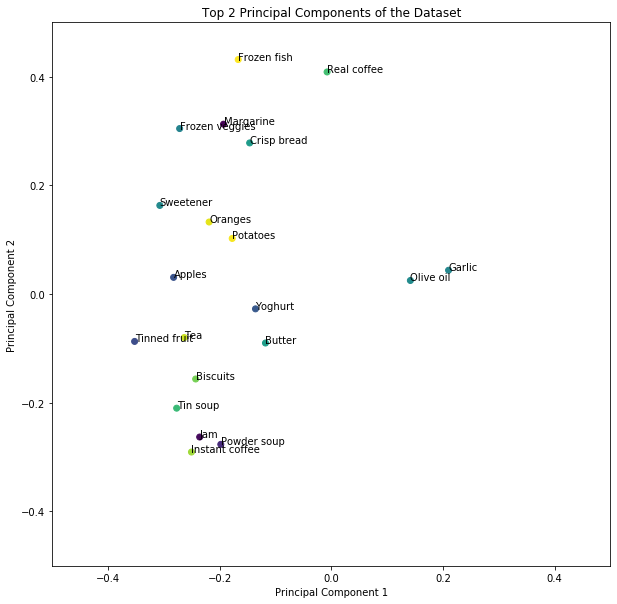

In [256]:
# 3)
plt.figure(figsize=(10, 10))
plt.axis([-0.5,0.5,-0.5,0.5])
plt.scatter(W[:,0], W[:,1], c=np.random.rand(n))
plt.title('Top 2 Principal Components of the Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i in range(n):
    plt.annotate(foods[i+1], (W[i,0], W[i,1]))

plt.savefig('Composition of Top 2 Principal Components.png', dpi=80)
plt.show()

The image above shows how much of each original dimension contributes to the first and second principal components. The first principal component is represented along the x-axis, and the second is represented along the y-axis.

The main thing that I see, is principal component 1 basically separates garlic and olive oil from the other foods. Also, real coffee has basically no influence on principal component 1. 

Principal component 2 seems to separate the foods that were separated from garlic and olive oil by principal component 1. Frozen vegetables and frozen fish were spearated from instant foods like instant coffee and powder soup. The dairy products butter and yogurt were not used much principal component 2, but the dairy substitute margarine was. Principal component 2 did not contain much information about olive oil and garlic use. 

**4) Now project each data point using the top two principal component vectors (thus now each data point will be represented using a two-dimensional vector). Draw a scatter plot of two-dimensional reduced representation for each country. What pattern can you observe?**

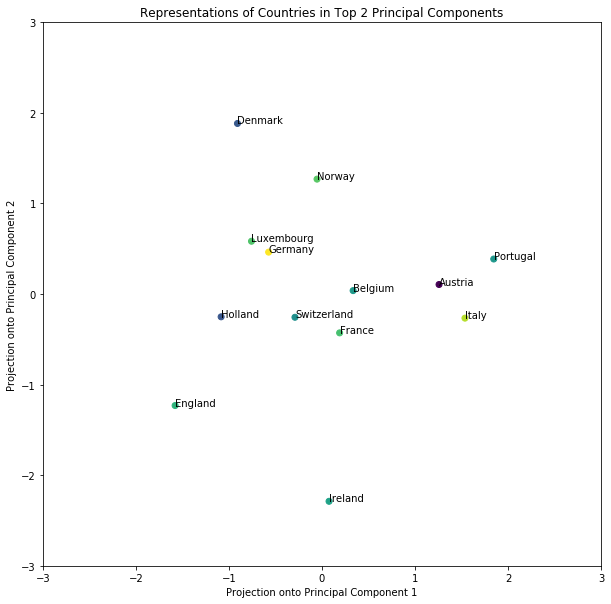

In [261]:
# 4)
plt.figure(figsize=(10, 10))
plt.axis([-3,3,-3,3])
plt.scatter(dim1, dim2, c=np.random.rand(m))
plt.title('Representations of Countries in Top 2 Principal Components')
plt.xlabel('Projection onto Principal Component 1')
plt.ylabel('Projection onto Principal Component 2')
for i in range(m):
    plt.annotate(countries[i], (dim1[i], dim2[i]))

plt.savefig('Countries Projected onto Principle Component Space.png', dpi=80)
plt.show()

<img src="Europe.png">

The image above shows how each country is group according to the projection of each country onto the first and second principal components. 

Ireland was barely represented along principal component 1 (which was mostly garlic and olive oil), but was heavily represented along the negative axis of principal component two (which was mostly biscuits, tin soup, jam, powder soup, and instand coffee). 

Denmark and Norway were near each other, along the positive axis of principal component 2 (frozen fish, frozen vegetables, margarine, real coffee, crisp bread). 

Italy and Austria were clustered along the positive axis of principal component one (olive oil and garlic), along with Portugal.

Belgium, Switzerland, France, Holland, Luxembourg, and Germany were all clustered together in the "middle" of the space. 

This very closely resembles the geographical representation of each country, as can be seen in the map above. With the exception of Portugal, and England/Ireland, all of the countries seem to be clustered with their nearest geographical neighbors.